## Writing ome.zarr data from a CZI image file

* Read the CZI image and its metadata into an 6D array
* reduce dimensionality to a 5D array
* write array into an OME-ZARR file
* open the OME-ZARR in Napari

In [1]:
# check if the notebook runs in Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
  # Install dependencies
  ! pip install --upgrade pip
  ! pip install czitools
  ! pip install ipyfilechooser

In [3]:
from czitools import metadata_tools as czimd
from czitools import read_tools, write_tools
import napari
from pathlib import Path
import ome_zarr.reader
import ome_zarr.scale
import ome_zarr.writer
from ome_zarr.io import parse_url
import shutil
import zarr
import requests
import os

if not IN_COLAB:
    import napari

zarr.__version__

'2.15.0'

In [4]:
# try to find the folder with data and download otherwise from GitHub.

# Folder containing the input data
if IN_COLAB:
    INPUT_FOLDER = 'data/'
if not IN_COLAB:
    INPUT_FOLDER = '../../data/'

# Path to the data on GitHub
GITHUB_IMAGES_PATH = "https://raw.githubusercontent.com/sebi06/czitools/main/data.zip"

# Download data
if not (os.path.isdir(INPUT_FOLDER)):
    compressed_data = './data.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_IMAGES_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)

    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')

In [5]:
if IN_COLAB:
    filepath = os.path.join(os.getcwd(), "data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi")
    zarr_path = Path(filepath[:-4] + ".ome.zarr")

if not IN_COLAB:
    defaultdir = os.path.join(Path(os.getcwd()).resolve().parents[1], "data")
    filepath = os.path.join(defaultdir, "CellDivision_T=3_Z=5_CH=2_X=240_Y=170.czi")
    zarr_path = defaultdir / Path(filepath[:-4] + ".ome.zarr")

print(zarr_path)

# check if path exists
remove = True
if zarr_path.exists() and remove:
    shutil.rmtree(zarr_path, ignore_errors=False, onerror=None)

/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr


In [6]:
# get the metadata at once as one big class
mdata = czimd.CziMetadata(filepath)
print("Number of Scenes: ", mdata.image.SizeS)
scene_id = 0

Number of Scenes:  None


In [7]:
dimorder = "STCZYX"

array, mdata, dim_string6d = read_tools.read_6darray(filepath, output_order=dimorder)

array = array[scene_id, ...]
print(f"Array Shape: {array.shape}")
print(f"Dimension String: {dim_string6d}")

Reading 2D planes: 0 2Dplanes [00:00, ? 2Dplanes/s]

Array Shape: (3, 2, 5, 170, 240)
Dimenison String: STCZYX


In [8]:
ngff_version = ome_zarr.format.CurrentFormat().version
print(f"Using ngff format version: {ngff_version}")

# write the image data
store = parse_url(zarr_path, mode="w").store
root = zarr.group(store=store)
root.info
print(root.tree())

Using ngff format version: 0.4
/


In [10]:
omezarr_dimorder = dimorder.replace("S", "").lower()
print(f"OME-ZARR Dimension Order: {omezarr_dimorder}")

# write the OME-ZARR file - make sure to use the correct order for the dimensions
ome_zarr.writer.write_image(
    image=array,
    group=root,
    axes=omezarr_dimorder,
    storage_options=dict(chunks=array.shape),
)

# convince yourself that the data is there
for child in zarr_path.iterdir():
    print(child)

OME-ZARR Dimension Order: tczyx
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/.zattrs
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/.zgroup
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/0
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/1
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/2
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/3
/datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr/4


In [11]:
loc = ome_zarr.io.parse_url(zarr_path, mode="r")  # open the file in read mode
# this will return a reader object, which enables access to the individual resolution levels 
zarr_reader = ome_zarr.reader.Reader(loc).zarr

In [12]:
# the 'load' functionality returns the specified resolution data as a dask array
res0 = zarr_reader.load("0")

In [13]:
# the dask array can be used for lazy computation, or converted to numpy via .compute()
# for more information on dask arrays check out https://docs.dask.org/en/latest/array.html
full_image_npy = res0.compute()
print(full_image_npy.shape)

(3, 2, 5, 170, 240)


In [14]:
# data slices can be used to select parts of the image.
# these will also be returned as dask arrays
sub_image = res0[:, :, :, :128, :128]
sub_image_npy = sub_image.compute()
print(sub_image_npy.shape)

(3, 2, 5, 128, 128)


## Using napari with ome.zarr

Use the napari plugin installed with `napari-ome-zarr` to open ome.zarr files directly.

In [15]:
# this is how we can open the file we just write in napari
viewer = napari.Viewer()
viewer.open(zarr_path)

[<Image layer 'CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome' at 0x7f8e0da12b20>]

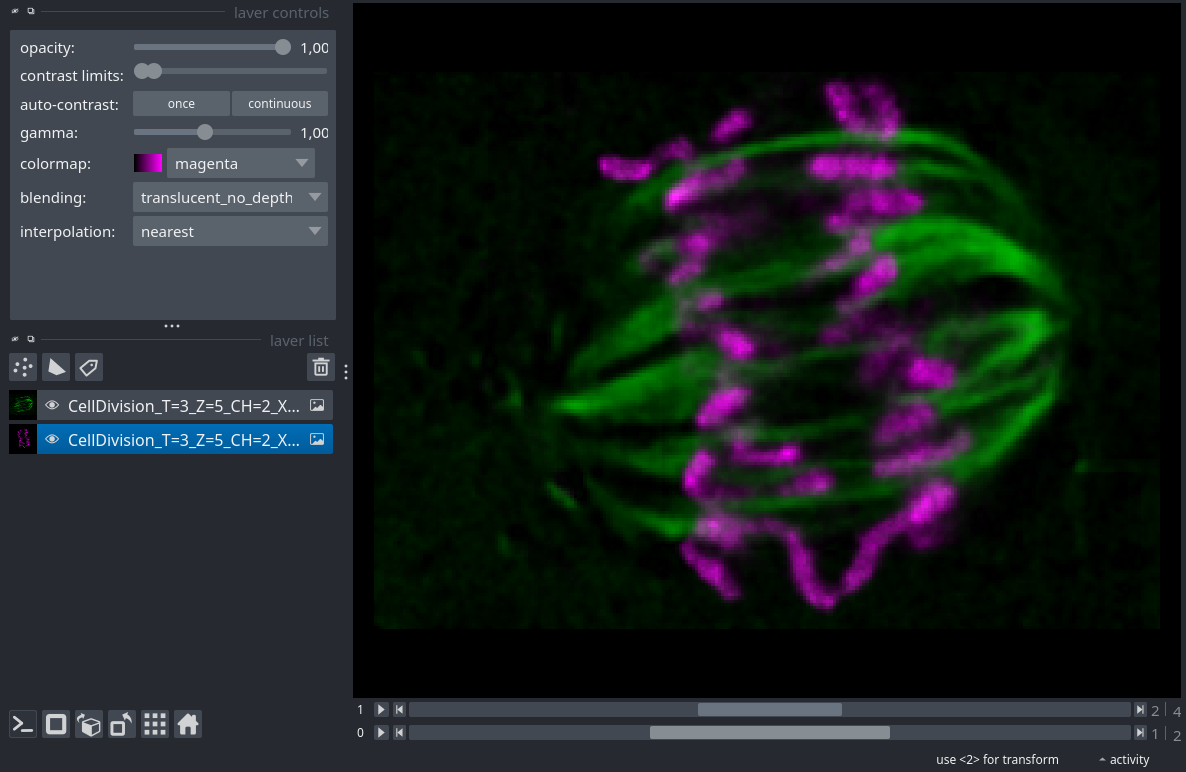

In [16]:
napari.utils.nbscreenshot(viewer)

## Simply writing OME-ZARR by using a helper function

The idea is to wrap the code from above into a function that simplifies the process

- read array from CZI image file
- use function do directly write OME-ZARR
- open OME-ZARR in Napari

In [17]:
# write OME-ZARR using utility function
zarr_path = write_tools.write_omezarr(array,
                                      zarr_path=zarr_path,
                                      axes=omezarr_dimorder,
                                      overwrite=True)

Using ngff format version: 0.4
Finished writing OME-ZARR to: /datadisk1/Github/czitools/data/CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome.zarr


In [18]:
# this is how we can open the file we just write in napari
viewer = napari.Viewer()
viewer.open(zarr_path)

[<Image layer 'CellDivision_T=3_Z=5_CH=2_X=240_Y=170.ome' at 0x7f8f71304700>]

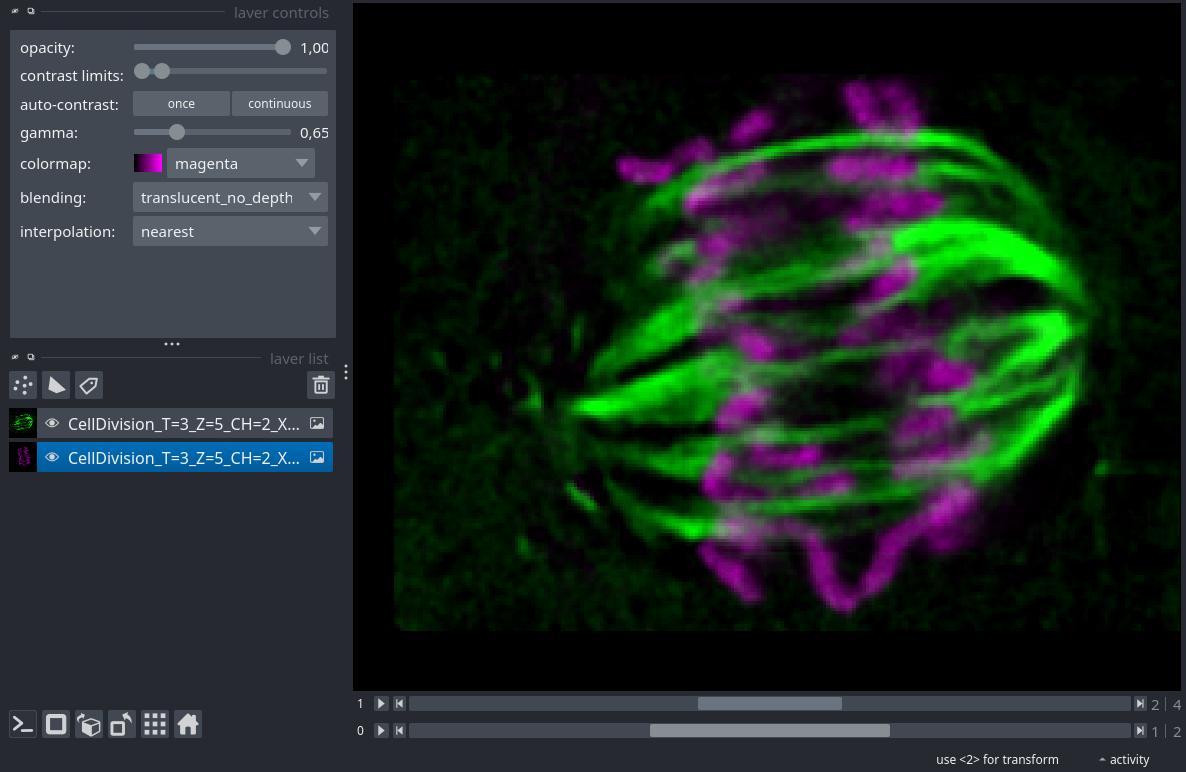

In [19]:
napari.utils.nbscreenshot(viewer)